In [1]:
## Imports

%matplotlib inline
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from ts_outlier_detection import *
from ts_outlier_detection.plotting import *

from gwpy.signal import filter_design
from gwpy.timeseries import TimeSeries

from tqdm.notebook import tqdm

In [2]:
## CONSTANTS

BANDPASS = (20, 500)

DET = 'L1'

SCATTERED_LIGHT = [
    1253331031.313,
    1253362400.688,
    1245551779.625,
    1242316342.688,
    1250543149.438
]

BLIP = [
    1241313885.077,
    1241059759.294,
    1244759854.760,
    1248201703.322,
    1246580860.546
]

TOMTE = [
    1249463266.059,
    1243933155.996,
    1253921604.105,
    1244937658.590,
    1252535668.965   
]

KOI_FISH = [
    1250427024.302,
    1242879781.401,
    1244734158.697,
    1247766717.341,
    1250224606.204
]

LOW_FREQUENCY_BURST = [
    1245716539.797,
    1242088345.969,
    1244387013.719,
    1246892010.219,
    1242347386.297
]

REPEATING_BLIPS = [
    1245975282.913,
    1249351602.411,
    1246491005.653,
    1252535302.624,
    1246605798.116
]

ALL = {
    'Scattered Light': SCATTERED_LIGHT,
    'Blip': BLIP,
    'Tomte': TOMTE,
    'Koi Fish': KOI_FISH,
    'Low Frequency Burst': LOW_FREQUENCY_BURST,
    'Repeating Blips': REPEATING_BLIPS
}

CHIRPS = {
    'GW170817 (m1 1.46, m2 1.27, SNR 33.0, dist 40)': ('H1', 1187008880),
    'GW190412 (m1 30.1, m2 8.3, SNR 18.9, dist 740)': ('L1', 1239082261),
    'GW190521 (m1 95.3, m2 69.0, SNR 14.4, dist 3920)': ('L1', 1242442967),
    'GW190521_074359 (m1 32.2, m2 32.8, SNR 24.4, dist 1240)': ('L1', 1242459857),
    'GW190814 (m1 23.2, m2 2.6, SNR 22.2, dist 240)': ('L1', 1249852254)
}

# Definitions
## LOF stuff

In [3]:
## Animator and plotting classes

class LOFMaxStdWindowAnimation:
    def __init__(
        self, data,
        times=None, n_range=range(4,30), n_neighbors=20,
        xlim=None, interval=500):
        
        if len(data.shape) != 1:
            raise ValueError("Input must be 1D time series")
        self.data = data
        if times is None:
            times = np.arange(0,data.size)
        self.times = times
        self.n_range = list(n_range)
        self.n_neighbors = n_neighbors
        self.fig, self.axs = plt.subplots(3, 1, figsize=(8,12))
        self.xlim = xlim
        self.anim = animation.FuncAnimation(
            self.fig, self.animate,
            init_func=self.setup_plot,
            frames=tqdm(n_range),
            interval=interval,
            blit=True
        )

    def setup_plot(self):
        blank = np.zeros(0)
        clf = WindowedLocalOutlierFactor(
            window=3, crit_sigma=3, n_neighbors=self.n_neighbors)
        self.plots = [
            self.axs[0].plot(blank, blank)[0],
            self.axs[0].plot(blank, blank)[0],
            self.axs[1].plot(blank, blank)[0],
            self.axs[1].scatter(blank, blank),
            self.axs[2].plot(blank, blank)[0],
            self.axs[2].scatter(blank, blank)
        ]
        
        self.axs[0].set_title('Peak LOF deviation from mean per windowing size')
        self.axs[0].set_ylabel('Peak LOF deviation ($\sigma$)')
        self.axs[0].set_xlabel('Window size')
        self.axs[1].set_title('LOF Detections in Time Series')
        self.axs[1].set_ylabel('time series')
        
        if self.xlim is not None:
            self.axs[1].set_xlim(*self.xlim)
            self.axs[2].set_xlim(*self.xlim)
        
        self.axs[1].get_shared_x_axes().join(self.axs[1], self.axs[2])
        self.axs[1].set_xticklabels([])
        self.axs[2].set_xlabel('times')
        self.axs[2].set_ylabel('LOF')
        self.fig.tight_layout()
        
        self.max_lofs = []
        self.curr_range = []
        
        return self.plots

    def animate(self, n):
        clf = WindowedLocalOutlierFactor(
            dims=n, crit_sigma=3, n_neighbors=self.n_neighbors)
        clf.fit(self.data, self.times)
        is_outlier = clf.get_outlier_indices()
        
        data, times = clf.get_truncated_data()
        
        max_dev = abs(np.max(clf.lofs_) - np.mean(clf.lofs_) / np.std(clf.lofs_))
        self.max_lofs.append(max_dev)
        self.curr_range.append(n)
        new_outliers = np.stack((times[is_outlier], data[is_outlier]), axis=-1)
        new_lof_detections = np.stack((times[is_outlier], clf.lofs_[is_outlier]), axis=-1)
        
        # Clear previous frame
        for plot in self.plots:
            plot.remove()
        # Generate new plots
        self.plots = [
            self.axs[0].plot(self.curr_range, self.max_lofs, 'c-', zorder=1)[0],
            self.axs[0].plot(n, max_dev, 'ko', zorder=2)[0],
            *plot_ts_outliers(clf, self.axs[1:])
        ]
        
        return self.plots
    
    def save(self, *args, **kwargs):
        return self.anim.save(*args, **kwargs)
    
    def show(self, *args, **kwargs):
        return HTML(self.anim.to_html5_video(*args, **kwargs))

## More graphing things

In [4]:
def overlay_on_omega(times, data, ts, outseg=None, title=None, ylabel=None, plot_kwargs={}):
    spec = ts.q_transform(frange=BANDPASS, outseg=outseg).plot()
    spec.colorbar(label="Normalized energy")
    ax1 = spec.gca()
    ax2 = ax1.twinx()
    ax2.plot(times, data, **plot_kwargs)
    ax2.patch.set_alpha(0)
    if outseg is not None:
        ax1.set_xlim(*outseg)
        ax2.set_xlim(*outseg)
    if title is not None:
        spec.suptitle(title)
    if ylabel is not None:
        ax2.set_ylabel(ylabel)

def detections_over_omega(ts, detections, outseg=None, title=None, plot_kwargs={}):
    spec = ts.q_transform(frange=BANDPASS, outseg=outseg).plot()
    spec.colorbar(label="Normalized energy")
    ax = spec.gca()
    lines = ts.times.value[detections]
    ax.vlines(lines, *BANDPASS, **plot_kwargs)
    if title is not None:
        spec.suptitle(title)

## Data Processing

In [5]:
## Data fetching and pre-processing functions

def downsample_timeseries(data, ratio, sampler=None):
    ds = data[::ratio]
    if sampler is not None:
        data = np.append(data, np.full(data.size % ratio, data[-1]))
        bins = data.reshape(ratio, -1)
        ds = sampler(bins)
    return ds

def get_processed_event(
    detector, gps_time, length=10, offset=0, edges=1, downsample=1, sampler=None
):
    ts = get_raw_event(detector, gps_time, length, offset, edges)
    border = int(edges/ts.dt.value)
    ts = preprocess_timeseries(ts)[border:-border]
    return downsample_timeseries(ts, downsample, sampler)


def get_raw_event(detector, gps_time, length=10, offset=0, edges=1):
    bracket = edges + length/2
    t0 = gps_time - bracket + offset
    t1 = gps_time + bracket + offset
    return TimeSeries.fetch_open_data(detector, t0, t1, cache=True)
    

def preprocess_timeseries(ts, bp=BANDPASS):
    # Whiten
    ts = ts.whiten()
    # Bandpass
    ts = ts.bandpass(*bp)
    return ts

# Playground
## LOF stuff

In [ ]:
window_n = 100
clf = WindowedLocalOutlierFactor(dims=window_n, crit_sigma=3, n_neighbors=20)

for k, (name, events) in enumerate(ALL.items()):
    print(f'NOW PLOTTING {name}s')
    rows = len(events)
    
    # LOF
    fig, axs = plt.subplots(rows, 2, figsize=(10, 2*rows))
    fig.suptitle(f'{name} Events')
    fig.text(0.5, 0, 'GPS Time (s)', ha='center')
    fig.text(0, 0.5, 'Strain', va='center', rotation='vertical')
    fig.text(1, 0.5, 'LOF', va='center', rotation='vertical')
    
    for i in tqdm(range(rows)):
        hdata = get_processed_event(DET, events[i], length=10, downsample=4)
        data = hdata.value
        times = hdata.times.value
        clf.fit(data, times)
        data, times = clf.get_truncated_data()
        plot_ts_outliers(clf, axs[i])

In [ ]:
hdata = get_processed_event(DET, BLIP[0], length=4, downsample=1)

#fig, ax = plt.subplots(figsize=(8,8))
#tsne_plot = get_rolling_windows(hdata.value, 100)
#plot_2d_scatter(tsne_plot, ax)

#fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4.096.hdf5'
#ts = TimeSeries.read(fn,format='hdf5.losc')[::100]
#ts = ts[int(11*ts.size/22):int(13*ts.size/22)]
#ts = ts[int(ts.size/4):int(ts.size/2)]
#hdata = ts

In [ ]:
## For the whole animation

anim = LOFMaxStdWindowAnimation(
    hdata.value,
    hdata.times.value,
    n_range=range(5,1001,10),
    interval=200
)
plt.close()
anim.show()

In [ ]:
event = SCATTERED_LIGHT[2]
frame = 10

hdata = get_processed_event(DET, event, length=frame, downsample=1)
times = hdata.times.value
data = hdata.value
windows = get_rolling_windows(data, 1000)
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(windows)
lofs = -clf.negative_outlier_factor_

raw_data = get_raw_event(DET, event, length=frame, edges=0)
plot_kwargs = {'style': 'w-', 'alpha': 0.2}
middle = times[int(times.size/2)]
xlim = None #(middle - 0.5, middle + 0.5)
overlay_on_omega(times, lofs, raw_data, outseg=xlim, ylabel='LOF')

## TOF Stuff

In [ ]:
frame = 10
figures = []
ctof = TemporalOutlierFactor(dims=2, n_neighbors=20, event_length=2**13)

for k, (name, events) in enumerate(ALL.items()):
    print(f'NOW PLOTTING {name}s')
    rows = len(events)
    
    for i in tqdm(range(rows)):
        event = events[i]
        try:
            raw_data = get_raw_event(DET, event, length=frame, edges=0)
            hdata = get_processed_event(DET, event, length=frame, downsample=1)
        except ConnectionError as e:
            print(e)
            continue
        times = hdata.times.value
        data = hdata.value
        ctof.fit(data, times)
        data, times = ctof.get_truncated_data()
        
        fig = plt.figure(figsize=(12,6), constrained_layout=True)
        fig.suptitle(f'{name} {i+1}')
        gs = fig.add_gridspec(2, 4)
        rect1 = fig.add_subplot(gs[0,:2])
        rect1.set_ylabel('Strain')
        rect2 = fig.add_subplot(gs[1,:2], sharex=rect1)
        rect2.set_ylabel('TOF')
        rect2.set_xlabel('GPS Time (s)')
        square = fig.add_subplot(gs[:, 2:])
        square.set_xlabel('Time-Delay Embedded Phase Space')
        
        plot_ts_outliers(ctof, [rect1, rect2])
        plot_2d_phase_space(ctof.embedded_data, square, outlier_ids=ctof.tof_detections_)
        
        figures.append(fig)

In [ ]:
for fig in figures: fig.close()

In [ ]:
hdata = get_processed_event(DET, BLIP[0], length=4, downsample=1)
x0 = hdata.times.value[0] + 1.8
x1 = hdata.times.value[0] + 2.2

In [ ]:
anim = TOFEmbedDimsAnimation(
    hdata.value,
    hdata.times.value,
    n_range=range(3,21)
)
plt.close()
anim.show()

In [ ]:
event = SCATTERED_LIGHT[2]
frame = 4

hdata = get_processed_event(DET, event, length=frame, downsample=1)
times = hdata.times.value
data = hdata.value
res_df = detect_outlier(
    pd.DataFrame(data)[[0]], cutoff_n=100, n_neighbors=20, embedding_dimension=3)
tofs = res_df.TOF_score

raw_data = get_raw_event(DET, event, length=frame, edges=0)
plot_kwargs = {'style': 'w-', 'alpha': 0.2}
middle = times[int(times.size/2)]
xlim = None #(middle - 0.5, middle + 0.5)
overlay_on_spectrogram(times, tofs, raw_data, outseg=xlim, ylabel='TOF')

# Comparing TOF detections over different glitch types

In [6]:
# Grab one of each glitch class
length = 10
downsample = 1
glitch_hdata = [
    get_processed_event(DET, glitches[2], length=length, downsample=downsample)
    for glitches in ALL.values()
]

In [ ]:
# Figure setup
classes = len(ALL)
fig = plt.figure(figsize=(9*classes,6), constrained_layout=True)
gs = fig.add_gridspec(2, classes)

tax = fig.add_subplot(gs[0,0])
trest = [fig.add_subplot(gs[0,i]) for i in range(1, classes)]
tax.set_ylabel('Strain')
bax = fig.add_subplot(gs[1,0], sharex=tax)
brest = [fig.add_subplot(gs[1,i], sharex=trest[i-1]) for i in range(1, classes)]
bax.set_ylabel('TOF')
fig.text(0.5, 0, 'GPS Time (s)', ha='center')

top_axes = [tax] + trest
bottom_axes = [bax] + brest

for i, key in enumerate(ALL.keys()):
    top_axes[i].set_title(key)

plots = []
def animate(frame):
    # vary n_neighbors
    ctof = TemporalOutlierFactor(dims=2, n_neighbors=frame, event_length=2**13)
    
    global plots
    for plot in plots:
        plot.remove()
    plots = []
    for i, hdata in enumerate(glitch_hdata):
        data = hdata.value
        times = hdata.times.value
        ctof.fit(data, times)
        plots.extend(plot_ts_outliers(ctof, (top_axes[i], bottom_axes[i])))
        fig.suptitle(f'k = {frame}')
    return plots

n_range = range(4, 101)
anim = animation.FuncAnimation(
    fig, animate, frames=tqdm(n_range), interval=200, blit=True)
plt.close()
HTML(anim.to_html5_video())

In [ ]:
# Figure setup
classes = len(ALL)
fig = plt.figure(figsize=(9*classes,6), constrained_layout=True)
gs = fig.add_gridspec(2, classes)

tax = fig.add_subplot(gs[0,0])
trest = [fig.add_subplot(gs[0,i]) for i in range(1, classes)]
tax.set_ylabel('Strain')
bax = fig.add_subplot(gs[1,0], sharex=tax)
brest = [fig.add_subplot(gs[1,i], sharex=trest[i-1]) for i in range(1, classes)]
bax.set_ylabel('LOF')
fig.text(0.5, 0, 'GPS Time (s)', ha='center')

top_axes = [tax] + trest
bottom_axes = [bax] + brest

for i, key in enumerate(ALL.keys()):
    top_axes[i].set_title(key)

plots = []
def animate(frame):
    # vary n_neighbors
    ctof = WindowedLocalOutlierFactor(n_neighbors=frame, crit_sigma=3)
    
    global plots
    for plot in plots:
        plot.remove()
    plots = []
    for i, hdata in enumerate(glitch_hdata):
        data = hdata.value
        times = hdata.times.value
        ctof.fit(data, times)
        plots.extend(plot_ts_outliers(ctof, (top_axes[i], bottom_axes[i])))
        fig.suptitle(f'k = {frame}')
    return plots

n_range = range(3, 101)
anim = animation.FuncAnimation(
    fig, animate, frames=tqdm(n_range), interval=200, blit=True)
plt.close()
HTML(anim.to_html5_video())

In [ ]:
# Figure setup
classes = len(ALL)
fig = plt.figure(figsize=(9*classes,6), constrained_layout=True)
gs = fig.add_gridspec(2, classes)

tax = fig.add_subplot(gs[0,0])
trest = [fig.add_subplot(gs[0,i]) for i in range(1, classes)]
tax.set_ylabel('Strain')
bax = fig.add_subplot(gs[1,0], sharex=tax)
brest = [fig.add_subplot(gs[1,i], sharex=trest[i-1]) for i in range(1, classes)]
bax.set_ylabel('TOF')
fig.text(0.5, 0, 'GPS Time (s)', ha='center')

top_axes = [tax] + trest
bottom_axes = [bax] + brest

for i, key in enumerate(ALL.keys()):
    top_axes[i].set_title(key)

plots = []
def animate(frame):
    # vary delay
    ctof = TemporalOutlierFactor(dims=2, delay=frame, n_neighbors=20, event_length=2**13)
    
    global plots
    for plot in plots:
        plot.remove()
    plots = []
    for i, hdata in enumerate(glitch_hdata):
        data = hdata.value
        times = hdata.times.value
        ctof.fit(data, times)
        plots.extend(plot_ts_outliers(ctof, (top_axes[i], bottom_axes[i])))
        fig.suptitle(f'tau = {frame}')
    return plots

n_range = range(1, 101)
anim = animation.FuncAnimation(
    fig, animate, frames=tqdm(n_range), interval=200, blit=True)
plt.close()
HTML(anim.to_html5_video())

In [ ]:
# Figure setup
classes = len(ALL)
fig = plt.figure(figsize=(9*classes,6), constrained_layout=True)
gs = fig.add_gridspec(2, classes)

tax = fig.add_subplot(gs[0,0])
trest = [fig.add_subplot(gs[0,i]) for i in range(1, classes)]
tax.set_ylabel('Strain')
bax = fig.add_subplot(gs[1,0], sharex=tax)
brest = [fig.add_subplot(gs[1,i], sharex=trest[i-1]) for i in range(1, classes)]
bax.set_ylabel('TOF')
fig.text(0.5, 0, 'GPS Time (s)', ha='center')

top_axes = [tax] + trest
bottom_axes = [bax] + brest

for i, key in enumerate(ALL.keys()):
    top_axes[i].set_title(key)

plots = []
def animate(frame):
    # vary embedding dimension
    ctof = TemporalOutlierFactor(dims=frame, n_neighbors=20, event_length=2**13)
    
    global plots
    for plot in plots:
        plot.remove()
    plots = []
    for i, hdata in enumerate(glitch_hdata):
        data = hdata.value
        times = hdata.times.value
        ctof.fit(data, times)
        plots.extend(plot_ts_outliers(ctof, (top_axes[i], bottom_axes[i])))
        fig.suptitle(f'dims = {frame}')
    return plots

n_range = range(2, 15)
anim = animation.FuncAnimation(
    fig, animate, frames=tqdm(n_range), interval=500, blit=True)
plt.close()
HTML(anim.to_html5_video())

In [ ]:
# Figure setup
classes = len(ALL)
fig = plt.figure(figsize=(9*classes,6), constrained_layout=True)
gs = fig.add_gridspec(2, classes)

tax = fig.add_subplot(gs[0,0])
trest = [fig.add_subplot(gs[0,i]) for i in range(1, classes)]
tax.set_ylabel('Strain')
bax = fig.add_subplot(gs[1,0], sharex=tax)
brest = [fig.add_subplot(gs[1,i], sharex=trest[i-1]) for i in range(1, classes)]
bax.set_ylabel('TOF')
fig.text(0.5, 0, 'GPS Time (s)', ha='center')

top_axes = [tax] + trest
bottom_axes = [bax] + brest

for i, key in enumerate(ALL.keys()):
    top_axes[i].set_title(key)

plots = []
def animate(frame):
    # vary embedding dimension
    ctof = WindowedLocalOutlierFactor(dims=frame, n_neighbors=20, crit_sigma=3)
    
    global plots
    for plot in plots:
        plot.remove()
    plots = []
    for i, hdata in enumerate(glitch_hdata):
        data = hdata.value
        times = hdata.times.value
        ctof.fit(data, times)
        plots.extend(plot_ts_outliers(ctof, (top_axes[i], bottom_axes[i])))
        fig.suptitle(f'dims = {frame}')
    return plots

n_range = range(5, 101, 5)
anim = animation.FuncAnimation(
    fig, animate, frames=tqdm(n_range), interval=500, blit=True)
plt.close()
HTML(anim.to_html5_video())

# Varying n_neighbors over different chirps

In [10]:
def plot_omegascan_detections(ax, ts, detections, ypos=BANDPASS[0]-10, **kwargs):
    image = ax.pcolormesh(ts.q_transform(**kwargs), vmin=0, vmax=15, zorder=1)
    plotx = ts.times.value[detections]
    ploty = np.full(ts.times.value.shape, ypos)[detections]
    markers, = ax.plot(plotx, ploty, 'k+', zorder=2)
    ax.set_ylim(0, 300)
    return [image, markers]

In [7]:
# Grab the chirps
length = 10
downsample = 1
chirp_hdata = [
    get_processed_event(det, ch, length=length, downsample=downsample) for det, ch in CHIRPS.values()
]

In [8]:
# Figure setup

classes = len(CHIRPS)
fig = plt.figure(figsize=(18, 6*classes), constrained_layout=True)
gs = fig.add_gridspec(2*classes, 2)

tops = []
bottoms = []
omegas = []
for i, key in enumerate(CHIRPS.keys()):
    bax = fig.add_subplot(gs[2*i+1,0])
    bax.set_ylabel('TOF')
    bax.set_xlabel('GPS Time (s)')
    bottoms.append(bax)
    tax = fig.add_subplot(gs[2*i,0], sharex=bax)
    tax.set_ylabel('Strain')
    tax.set_title(key)
    tops.append(tax)
    oax = fig.add_subplot(gs[2*i:2*i+2,1])
    oax.set_ylabel('Frequency (s)')
    oax.set_xlabel('GPS Time (s)')
    omegas.append(oax)
    
# Animation
plots = []
def animate(frame):
    # vary n_neighbors
    ctof = TemporalOutlierFactor(dims=2, n_neighbors=frame, event_length=2**13)
    
    global plots
    for plot in plots:
        plot.remove()
    plots = []
    for i, hdata in enumerate(chirp_hdata):
        data = hdata.value
        times = hdata.times.value
        ctof.fit(data, times)
        plots.extend(plot_ts_outliers(ctof, (tops[i], bottoms[i])))
        plots.extend(plot_omegascan_detections(omegas[i], hdata, ctof.get_outlier_indices()))
        fig.suptitle(f'k = {frame}')
    return plots

n_range = range(4, 26)
anim = animation.FuncAnimation(
    fig, animate, frames=tqdm(n_range), interval=500, blit=True)
plt.close()
HTML(anim.to_html5_video())

  0%|          | 0/22 [00:00<?, ?it/s]

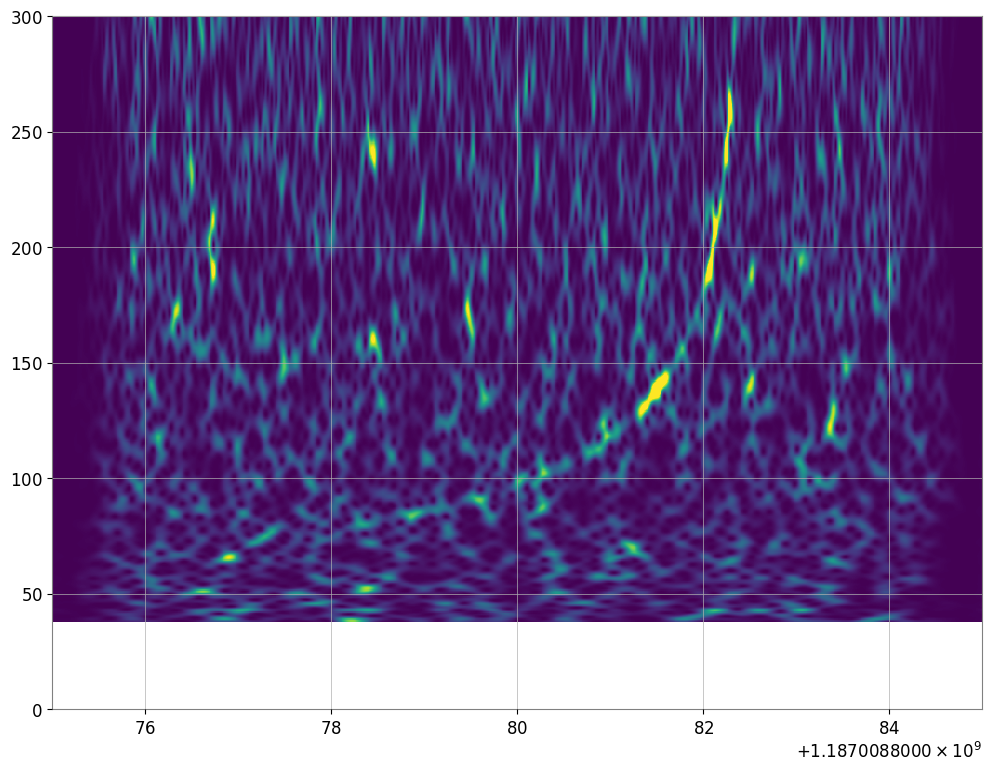

In [11]:
# omegascan test
ts = chirp_hdata[0]
fig, ax = plt.subplots(1, 1, figsize=(12,9))
plot_omegascan_detections(ax, ts, [], qrange=(45,50))